In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download die9origephit/nike-adidas-and-converse-imaged

 58% 9.00M/15.6M [00:01<00:01, 5.75MB/s]
100% 15.6M/15.6M [00:01<00:00, 10.9MB/s]


In [ ]:
! unzip nike-adidas-and-converse-imaged.zip

Archive:  nike-adidas-and-converse-imaged.zip
  inflating: test/adidas/0.jpg       
  inflating: test/adidas/1.jpg       
  inflating: test/adidas/10.jpg      
  inflating: test/adidas/11.jpg      
  inflating: test/adidas/12.jpg      
  inflating: test/adidas/13.jpg      
  inflating: test/adidas/14.jpg      
  inflating: test/adidas/15.jpg      
  inflating: test/adidas/16.jpg      
  inflating: test/adidas/17.jpg      
  inflating: test/adidas/18.jpg      
  inflating: test/adidas/19.jpg      
  inflating: test/adidas/2.jpg       
  inflating: test/adidas/20.jpg      
  inflating: test/adidas/21.jpg      
  inflating: test/adidas/22.jpg      
  inflating: test/adidas/23.jpg      
  inflating: test/adidas/24.jpg      
  inflating: test/adidas/25.jpg      
  inflating: test/adidas/26.jpg      
  inflating: test/adidas/27.jpg      
  inflating: test/adidas/28.jpg      
  inflating: test/adidas/29.jpg      
  inflating: test/adidas/3.jpg       
  inflating: test/adidas/30.jpg      
  in

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K

import os

### Load Data

In [ ]:
train_dir = './train'

IMG_SHAPE  = 224
batch_size = 32

In [ ]:
train_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =(IMG_SHAPE,IMG_SHAPE),
subset='training')

valid_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =(IMG_SHAPE,IMG_SHAPE),
subset='validation')

Found 711 files belonging to 3 classes.
Using 569 files for training.
Found 711 files belonging to 3 classes.
Using 142 files for validation.


In [ ]:
test_dir = './test'
test_set = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True,
                                                       seed=123, batch_size=batch_size, image_size=(IMG_SHAPE,IMG_SHAPE))

Found 114 files belonging to 3 classes.


### Explore Data

In [ ]:
class_names = train_set.class_names
print(class_names)

['adidas', 'converse', 'nike']


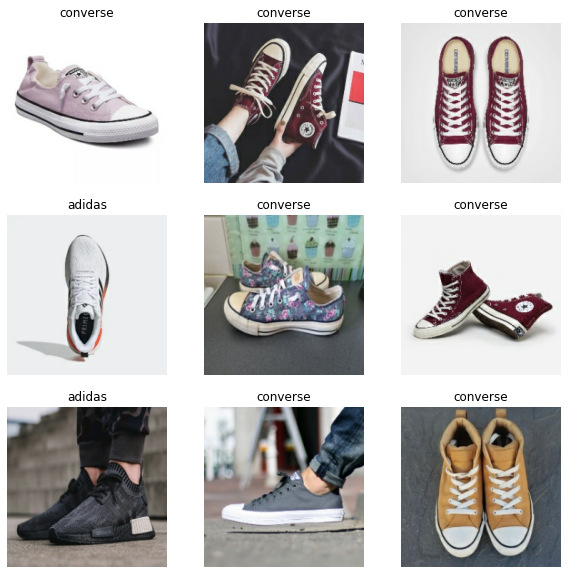

In [ ]:
plt.figure(figsize=(10, 10))
for images,labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
for val_image_batch, val_labels_batch in valid_set:
  print(val_image_batch.shape)
  print(val_labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
for test_image_batch, test_labels_batch in test_set:
  print(test_image_batch.shape)
  print(test_labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
train_dir_adidas = './train/adidas'
train_dir_nike = './train/nike'
train_dir_converse = './train/converse'

#Get total number of training images
print('Total number of training adidas images: ',len(os.listdir(train_dir_adidas)))
print('Total number of training nike images: ',len(os.listdir(train_dir_nike)))
print('Total number of training converse images: ',len(os.listdir(train_dir_converse)))

Total number of training adidas images:  237
Total number of training nike images:  237
Total number of training converse images:  237


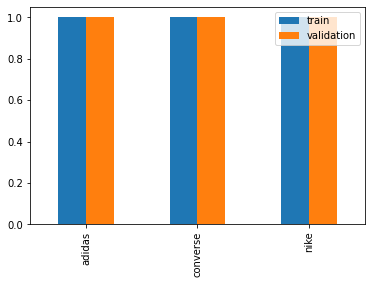

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_set, return_counts=True)
_, test_counts = np.unique(valid_set, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'validation': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Build the Model

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  print(layer.name)
  layer.trainable=False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(base_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20),
    keras.callbacks.ModelCheckpoint(
    filepath='vgg16_standart.h5',
    monitor='val_accuracy',
    save_best_only=True)
]

In [ ]:
initial_epochs = 80
history = model.fit(train_set, epochs = initial_epochs, validation_data=valid_set, callbacks= callbacks_list, batch_size = batch_size, verbose = 1)

Epoch 1/80
18/18 [==============================] - 22s 451ms/step - loss: 33.3655 - accuracy: 0.4517 - val_loss: 7.5008 - val_accuracy: 0.6972
Epoch 2/80
18/18 [==============================] - 4s 207ms/step - loss: 10.5329 - accuracy: 0.6837 - val_loss: 8.5690 - val_accuracy: 0.6901
Epoch 3/80
18/18 [==============================] - 4s 217ms/step - loss: 7.1603 - accuracy: 0.7311 - val_loss: 5.3839 - val_accuracy: 0.7324
Epoch 4/80
18/18 [==============================] - 4s 218ms/step - loss: 3.7785 - accuracy: 0.8155 - val_loss: 4.5440 - val_accuracy: 0.7887
Epoch 5/80
18/18 [==============================] - 4s 209ms/step - loss: 3.0357 - accuracy: 0.8471 - val_loss: 4.0322 - val_accuracy: 0.7465
Epoch 6/80
18/18 [==============================] - 4s 210ms/step - loss: 2.1242 - accuracy: 0.8735 - val_loss: 3.3577 - val_accuracy: 0.7817
Epoch 7/80
18/18 [==============================] - 4s 211ms/step - loss: 1.9264 - accuracy: 0.8576 - val_loss: 3.5988 - val_accuracy: 0.7535
Epo

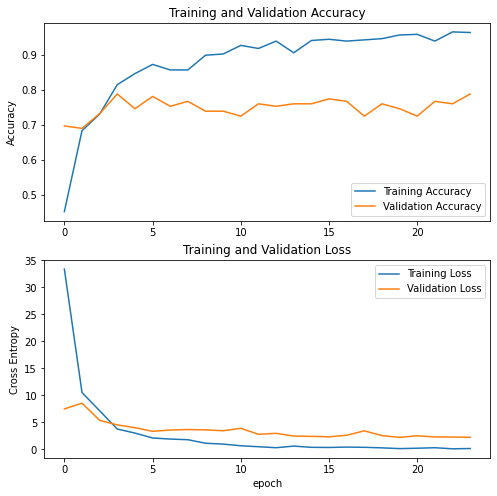

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Train the Model

In [ ]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(test_set)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 3s 745ms/step - loss: 1.3479 - accuracy: 0.8246
initial loss: 1.35
initial accuracy: 0.82


### Fine-tunning

In [ ]:
model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  23


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_set,
                  validation_data=valid_set, 
                  epochs=total_epochs,
                  initial_epoch=history.epoch[-1],
                  callbacks= callbacks_list)

Epoch 24/80
18/18 [==============================] - 4s 204ms/step - loss: 0.1009 - accuracy: 0.9754 - val_loss: 2.2533 - val_accuracy: 0.7887
Epoch 25/80
18/18 [==============================] - 4s 206ms/step - loss: 0.2320 - accuracy: 0.9631 - val_loss: 2.2533 - val_accuracy: 0.7887
Epoch 26/80
18/18 [==============================] - 4s 208ms/step - loss: 0.1536 - accuracy: 0.9701 - val_loss: 2.2533 - val_accuracy: 0.7887
Epoch 27/80
18/18 [==============================] - 4s 208ms/step - loss: 0.1829 - accuracy: 0.9701 - val_loss: 2.2533 - val_accuracy: 0.7887
Epoch 28/80
18/18 [==============================] - 4s 211ms/step - loss: 0.1407 - accuracy: 0.9666 - val_loss: 2.2533 - val_accuracy: 0.7887
Epoch 29/80
18/18 [==============================] - 4s 212ms/step - loss: 0.1386 - accuracy: 0.9719 - val_loss: 2.2533 - val_accuracy: 0.7887
Epoch 30/80
18/18 [==============================] - 4s 213ms/step - loss: 0.1282 - accuracy: 0.9684 - val_loss: 2.2533 - val_accuracy: 0.7887

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

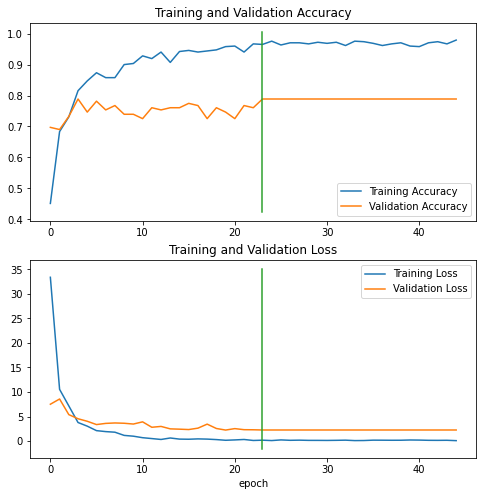

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.plot([23, 23],
          plt.ylim(), label='Start Fine Tuning')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.plot([23,23],
          plt.ylim(), label='Start Fine Tuning')

plt.xlabel('epoch')
plt.show()

In [ ]:
print("We got an accuracy of {:.2f}%".format(model.evaluate(test_set)[1]*100))

4/4 [==============================] - 1s 149ms/step - loss: 1.3479 - accuracy: 0.8246
We got an accuracy of 82.46%


In [ ]:
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
y_pred = []
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

Labels:
 [0 2 1 0 2 0 0 2 1 1 0 1 2 1 2 1 2 2 0 2 1 0 0 0 0 2 0 1 1 0 1 0]
Predictions:
 [2 2 1 0 2 0 2 0 1 1 0 1 2 1 2 1 2 1 0 2 2 0 0 2 0 2 0 1 1 0 1 2]


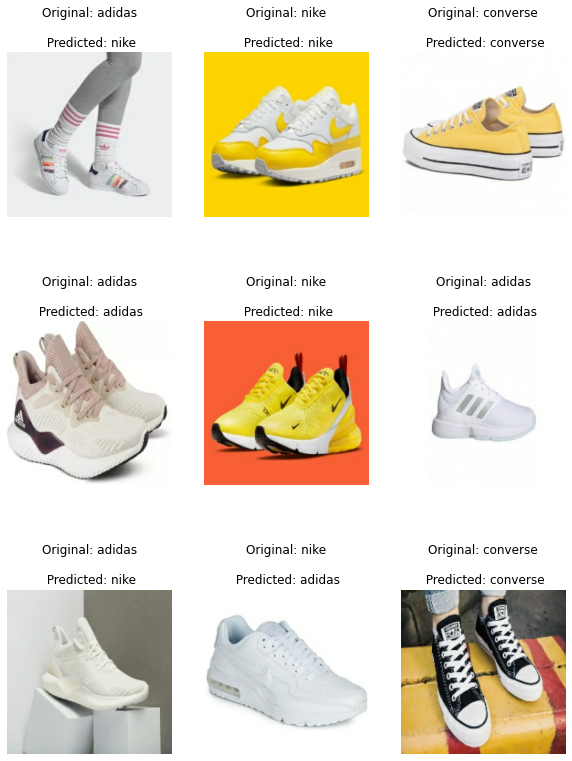

In [ ]:
plt.figure(figsize=(10, 14))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Original: {class_names[label_batch[i]]}\n\n Predicted: {class_names[y_pred[i]]}")
    plt.axis("off")

### Confusion Matrix

In [ ]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

pred = model.predict(test_set)
predictions = argmax(pred, axis=1) # return to label

Labels:
 [0 2 1 0 2 0 0 2 1 1 0 1 2 1 2 1 2 2 0 2 1 0 0 0 0 2 0 1 1 0 1 0]
Predictions:
 [2 2 1 0 2 0 2 0 1 1 0 1 2 1 2 1 2 1 0 2 2 0 0 2 0 2 0 1 1 0 1 2]


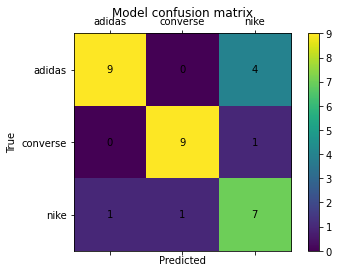

Accuracy : 78.12%
              precision    recall  f1-score   support

      adidas       0.90      0.69      0.78        13
    converse       0.90      0.90      0.90        10
        nike       0.58      0.78      0.67         9

    accuracy                           0.78        32
   macro avg       0.79      0.79      0.78        32
weighted avg       0.81      0.78      0.79        32



In [ ]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

#pred = model.predict(image_batch)
y_pred = []
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

cm = confusion_matrix(label_batch, y_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(label_batch, y_pred)
print("Accuracy : %.2f%%" % (accuracy*100.0))

print(classification_report(label_batch, y_pred, target_names=class_names))

### Refernces


*   https://medium.com/nerd-for-tech/image-classification-using-transfer-learning-vgg-16-2dc2221be34c


### K-fold

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
from keras.utils import np_utils
yhot = np_utils.to_categorical(y_pred)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
cmodel = KerasClassifier(build_fn=model, epochs=200, batch_size=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
from sklearn.model_selection import cross_val_score
result = cross_val_score(cmodel, image_batch, yhot, cv=kfold)
print("Result: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Result: nan% (nan%)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 153, in fit
    **self.filter_sk_params(self.build_fn.__call__))
  File "/us

In [ ]:
help(test_set.as_numpy_iterator())

Help on _NumpyIterator in module tensorflow.python.data.ops.dataset_ops object:

class _NumpyIterator(builtins.object)
 |  _NumpyIterator(dataset)
 |  
 |  Iterator over a dataset with elements converted to numpy.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  next(self)



### Helper Functions

In [ ]:
def prediction_label_comparison(model,test):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch).flatten()

    predictions = tf.nn.softmax(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        predict.append(pred)
    predict = np.array(predict)

    print('Labels:\n', label_batch)
    print('Predictions:\n',predict)

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")
    return label_batch , predict

In [ ]:
def test_model(list_test_path,model):

    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(IMG_SHAPE, IMG_SHAPE)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )

In [ ]:
def csv_builder(path_data,label_names):
    df = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_data)+'/'
        #train_folder_glioma = BASE_DIR+'glioma_tumor/'
        train_folder_name = BASE_DIR+name+'/'

        #train_annotation = BASE_DIR+'annotated_train_data/'

        files_in_train = sorted(os.listdir(train_folder_name))
        #files_in_annotated = sorted(os.listdir(train_annotation))

        image_names =[i for i in files_in_train]

        
        for x in image_names:
            df = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)
            
    return df

In [ ]:
def model_inputs(model2,train,val,test,callback):
    num_classes = 3
    epochs = 30
    model2.fit(
        train,
        validation_data=val,
        epochs=epochs,
        callbacks = callback,
        shuffle=False,
        verbose = 0
    )
    results = model2.evaluate(test)
    return results[0],results[1] , model

In [ ]:
from sklearn.model_selection import KFold

def cross_validation(n_splits,final_csv,test_csv,img_width,img_height,model):
    final_loss = 0
    final_acc = 0

    '''
    Seperating a dataframe for testing data
    '''
    ##
    final_csv = final_csv.sample(frac=1)
    ##
    Y = final_csv[['labels']]
    n = len(Y)
    kf = KFold(n_splits = 5)
    idg = ImageDataGenerator(
                         rescale=1./255)
    
    
    
    
    print('Performing cross validation...')
    test = idg.flow_from_dataframe(test_csv,
                                       x_col = "images",
                                       y_col = "labels",
                                       class_mode = "sparse",
                                       shuffle = True,
                                      target_size = (img_width,img_height),
                                      verbose = 0)

    for train_index, val_index in kf.split(np.zeros(n),Y):
        training_data = final_csv.iloc[train_index]
        validation_data = final_csv.iloc[val_index]
        train = idg.flow_from_dataframe(training_data,
                                        x_col = "images",
                                        y_col = "labels",
                                        class_mode = "sparse",
                                        shuffle = True,
                                        subset='training',
                                       target_size = (img_width,img_height),
                                       verbose = 0)
        val = idg.flow_from_dataframe(validation_data,
                                      x_col = "images",
                                      y_col = "labels",
                                      class_mode = "sparse",
                                      shuffle = True,
                                     target_size = (img_width,img_height),
                                     verbose = 0)	
             
        '''
        Passing the preprocessed data for model training
        '''
        loss,acc,returned_model = model_inputs(model,train,val,test, callbacks_list)
        final_loss += loss
        final_acc += acc
    return final_loss/n_splits , final_acc/n_splits , returned_model
   


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs= 3,
    callbacks = callbacks_list,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/3
18/18 [==============================] - 22s 448ms/step - loss: 43.7297 - accuracy: 0.4077 - val_loss: 9.1739 - val_accuracy: 0.6549
Epoch 2/3
18/18 [==============================] - 4s 219ms/step - loss: 11.1071 - accuracy: 0.6380 - val_loss: 5.7918 - val_accuracy: 0.7606
Epoch 3/3
18/18 [==============================] - 4s 210ms/step - loss: 6.3613 - accuracy: 0.7241 - val_loss: 4.5549 - val_accuracy: 0.7183


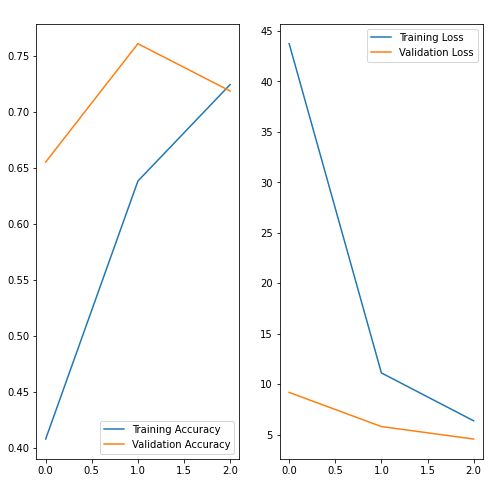

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [ ]:
results = model.evaluate(test_set)
print("test loss, test acc:", results)

4/4 [==============================] - 3s 732ms/step - loss: 3.0001 - accuracy: 0.7544
test loss, test acc: [3.000056028366089, 0.7543859481811523]


In [ ]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test_set.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.softmax(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[1 1 0 1 0 3 1 3 1 0 0 3 0 1 3 1 1 2 1 0 3 1 1 1 2 2 3 2 1 1 1 3 3 1 0 0 2
 3 3 1 3 3 1 2 3 2 0 3 1 2 3 2 1 1 1 1 2 0 1 2 0 1 1 2 2 1 3 0 0 1 2 3 2 0
 0 1 1 3 0 0 0 2 2 3 1]
[1 0 2 2 1 1 0 0 1 0 2 0 0 1 1 2 2 2 1 0 1 0 1 1 1 1 0 2 1 2 0 0 2 0 0 2 0
 2 2 0 1 0 0 2 1 0 2 2 2 1 1 2 1 1 1 2 1 1 0 2 2 1 1 1 1 2 0 2 0 2 0 0 1 2
 1 1 0 2 1 1 0 2 1 2 2 0 0 0 0 0 2 0 1 0 0 0 0 1 2 0 1 2 2 2 0 1 2 1 2 2 2
 0 1 2]


In [ ]:
import pandas as pd 
final_csv = csv_builder(train_dir,class_names)
final_csv

,images,labels
0,./train/adidas/100.jpg,adidas
1,./train/adidas/101.jpg,adidas
2,./train/adidas/102.jpg,adidas
3,./train/adidas/103.jpg,adidas
4,./train/adidas/104.jpg,adidas
...,...,...
706,./train/nike/95.jpg,nike
707,./train/nike/96.jpg,nike
708,./train/nike/97.jpg,nike
709,./train/nike/98.jpg,nike


In [ ]:
final_csv.to_csv('files_path.csv', header=None)

In [ ]:
path_of_csv = './files_path.csv'

In [ ]:
test_csv = csv_builder(test_dir,class_names)
test_csv

,images,labels
0,./test/adidas/0.jpg,adidas
1,./test/adidas/1.jpg,adidas
2,./test/adidas/10.jpg,adidas
3,./test/adidas/11.jpg,adidas
4,./test/adidas/12.jpg,adidas
...,...,...
109,./test/nike/5.jpg,nike
110,./test/nike/6.jpg,nike
111,./test/nike/7.jpg,nike
112,./test/nike/8.jpg,nike


In [ ]:
test_csv = test_csv.sample(frac=1)
test_csv

,images,labels
79,./test/nike/11.jpg,nike
102,./test/nike/32.jpg,nike
44,./test/converse/14.jpg,converse
4,./test/adidas/12.jpg,adidas
106,./test/nike/36.jpg,nike
...,...,...
64,./test/converse/32.jpg,converse
82,./test/nike/14.jpg,nike
31,./test/adidas/37.jpg,adidas
92,./test/nike/23.jpg,nike


### Defining number of Folds

In [ ]:
k = 5

* Now this csv file can be used to create a kfold split in the training data

### Cross Validation

In [ ]:
loss,acc,model = cross_validation(k,final_csv,test_csv,IMG_SHAPE,IMG_SHAPE,model)
print(loss,acc)

Performing cross validation...
Found 114 validated image filenames belonging to 3 classes.
Found 568 validated image filenames belonging to 3 classes.
Found 143 validated image filenames belonging to 3 classes.
4/4 [==============================] - 1s 141ms/step - loss: 0.5916 - accuracy: 0.7632
Found 569 validated image filenames belonging to 3 classes.
Found 142 validated image filenames belonging to 3 classes.
4/4 [==============================] - 1s 140ms/step - loss: 0.4670 - accuracy: 0.8158
Found 569 validated image filenames belonging to 3 classes.
Found 142 validated image filenames belonging to 3 classes.
4/4 [==============================] - 1s 141ms/step - loss: 0.4119 - accuracy: 0.8509
Found 569 validated image filenames belonging to 3 classes.
Found 142 validated image filenames belonging to 3 classes.
4/4 [==============================] - 1s 139ms/step - loss: 0.4494 - accuracy: 0.8509
Found 569 validated image filenames belonging to 3 classes.
Found 142 validated i

In [ ]:
from tensorflow.python.ops.gen_array_ops import tensor_strided_slice_update
labels_entire = []
pred_entire = []
for image_batch,label_batch in tensor_strided_slice_update.next():
    prediction = model.predict_on_batch(image_batch).flatten()

    predictions = tf.nn.softmax(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

AttributeError: ignored

In [ ]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test_set.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.softmax(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[1 3 2 1 1 3 0 0 0 1 1 0 2 0 3 2 1 1 1 1 2 2 0 2 0 0 2 1 1 1 2 1 2 1 0 3 0
 0 3 2 0 2 2 1 1 1 0 3 2 1 3 1 1 0 1 0 2 1 0 0 2 0 2 2 1 0 1 1 2 1 3 1 1 1
 3 2 0 2 1 0 3 2 0 3 1]
[0 2 1 0 0 0 0 2 0 1 2 2 2 0 2 2 0 1 1 0 2 2 1 0 1 2 1 0 0 1 0 1 0 1 2 0 0
 0 1 0 2 2 1 1 0 2 0 2 0 1 0 2 2 1 1 1 2 2 1 0 1 2 1 2 2 2 1 2 1 0 2 2 2 1
 1 1 1 0 2 1 2 1 0 0 2 0 2 1 1 2 1 1 0 0 1 0 0 0 0 2 0 1 0 1 1 0 0 2 2 1 2
 2 2 1]
